In [1]:
import pandas as pd
from pulp import *

In [36]:
!pip install openpyxl
!pip install pulp


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Plant Location  

#### Manufacturing variable costs

In [4]:
# Import Costs
manvar_costs = pd.read_excel('variable_costs.xlsx', index_col = 0)
manvar_costs

,USA,Germany,Japan,Brazil,India
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
Germany,13,13,13,13,13
Japan,10,10,10,10,10
Brazil,8,8,8,8,8
India,5,5,5,5,5


#### Freight costs

In [5]:
# Import Costs
freight_costs = pd.read_excel('freight_costs.xlsx', index_col = 0)
freight_costs

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,0,12250,1100,16100,8778
Germany,13335,0,8617,20244,10073
Japan,15400,22750,0,43610,14350
Brazil,16450,22050,28000,0,29750
India,13650,15400,24500,29400,0


#### Variable Costs

In [6]:
# Variable Costs
var_cost = freight_costs/1000 + manvar_costs 

var_cost

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,12.000,24.25,13.100,28.100,20.778
Germany,26.335,13.00,21.617,33.244,23.073
Japan,25.400,32.75,10.000,53.610,24.350
Brazil,24.450,30.05,36.000,8.000,37.750
India,18.650,20.40,29.500,34.400,5.000


#### Fixed Costs

In [7]:
# Import Costs
fixed_costs = pd.read_excel('fixed_cost.xlsx', index_col = 0)
fixed_costs

,Low,High
USA,6500,9500
Germany,4980,7270
Japan,6230,9100
Brazil,3230,4730
India,2110,6160


#### Plants Capacity

In [8]:
# Two types of plants: Low Capacity and High Capacity Plant
cap = pd.read_excel('capacity.xlsx', index_col = 0)
cap

,Low,High
Capacity (kUnits/month),,
USA,500,1500
Germany,500,1500
Japan,500,1500
Brazil,500,1500
India,500,3000


#### Demand 

In [30]:
# -- Demand
demand = pd.read_excel('demand.xlsx', header=1)
demand = demand.iloc[:, 1:]
demand.columns = ['Country', 'Demand']
demand.set_index('Country', inplace=True)
demand

,Demand
Country,
USA,2800000
Germany,90000
Japan,1700000
Brazil,145000
India,160000


In [23]:
from pulp import *

# Define Locations and Sizes
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low', 'High']

# Remove spaces in loc names for PuLP
clean_loc = [i.replace(" ", "_") for i in loc]

# Initialize Model
model = LpProblem("Capacitated_Plant_Location_Model", LpMinimize)

# Create Decision Variables
x = LpVariable.dicts("production", [(i, j) for i in clean_loc for j in clean_loc],
                     lowBound=0, upBound=None, cat='Continuous')

y = LpVariable.dicts("plant", [(i, s) for s in size for i in clean_loc], cat='Binary')

# Define Objective Function
model += (lpSum([fixed_costs.loc[i, s] * y[(i, s)] * 1000 for s in size for i in clean_loc])
          + lpSum([var_cost.loc[i, j] * x[(i, j)] for i in clean_loc for j in clean_loc]))

# Add Constraints
for j in clean_loc:
    model += lpSum([x[(i, j)] for i in clean_loc]) == demand.loc[j, 'Demand']

for i in clean_loc:
    model += lpSum([x[(i, j)] for j in clean_loc]) <= lpSum([cap.loc[i, s] * y[(i, s)] * 1000
                                                              for s in size])

# Solve Model
model.solve()

# Print Results
print("Total Costs = {:,} ($/Month)".format(int(value(model.objective))))
print('\n' + "Status: {}".format(LpStatus[model.status]))

# Store Results in Dictionaries
dict_plant = {}
dict_prod = {}

for v in model.variables():
    if "plant" in v.name:
        name = v.name.replace("plant_", "").replace("_", " ")
        dict_plant[name] = int(v.varValue)
    elif "production" in v.name:
        name = v.name.replace("production_", "").replace("_", " ")
        dict_prod[name] = v.varValue
    
    print(f"{name} = {v.varValue}")


Total Costs = 92,981,000 ($/Month)

Status: Optimal
('Brazil', 'High') = 0.0
('Brazil', 'Low') = 1.0
('Germany', 'High') = 0.0
('Germany', 'Low') = 0.0
('India', 'High') = 1.0
('India', 'Low') = 0.0
('Japan', 'High') = 1.0
('Japan', 'Low') = 0.0
('USA', 'High') = 1.0
('USA', 'Low') = 0.0
('Brazil', 'Brazil') = 145000.0
('Brazil', 'Germany') = 0.0
('Brazil', 'India') = 0.0
('Brazil', 'Japan') = 0.0
('Brazil', 'USA') = 0.0
('Germany', 'Brazil') = 0.0
('Germany', 'Germany') = 0.0
('Germany', 'India') = 0.0
('Germany', 'Japan') = 0.0
('Germany', 'USA') = 0.0
('India', 'Brazil') = 0.0
('India', 'Germany') = 90000.0
('India', 'India') = 160000.0
('India', 'Japan') = 0.0
('India', 'USA') = 1500000.0
('Japan', 'Brazil') = 0.0
('Japan', 'Germany') = 0.0
('Japan', 'India') = 0.0
('Japan', 'Japan') = 1500000.0
('Japan', 'USA') = 0.0
('USA', 'Brazil') = 0.0
('USA', 'Germany') = 0.0
('USA', 'India') = 0.0
('USA', 'Japan') = 200000.0
('USA', 'USA') = 1300000.0


In [34]:
list_low, list_high = [], []

for l in loc:
    for cap in ['Low', 'High']:
        key = f"('{l}', '{cap}')"  
        
        if key in dict_plant:
            if cap == 'Low':
                list_low.append(dict_plant[key])
            else:
                list_high.append(dict_plant[key])
        else:
            print(f"Warning: Key {key} not found!")
            if cap == 'Low':
                list_low.append(0)  
            else:
                list_high.append(0)

df_capacity = pd.DataFrame({'Location': loc, 'Low': list_low, 'High': list_high}).set_index('Location')

df_capacity


,Low,High
Location,,
USA,0,1
Germany,0,0
Japan,0,1
Brazil,1,0
India,0,1


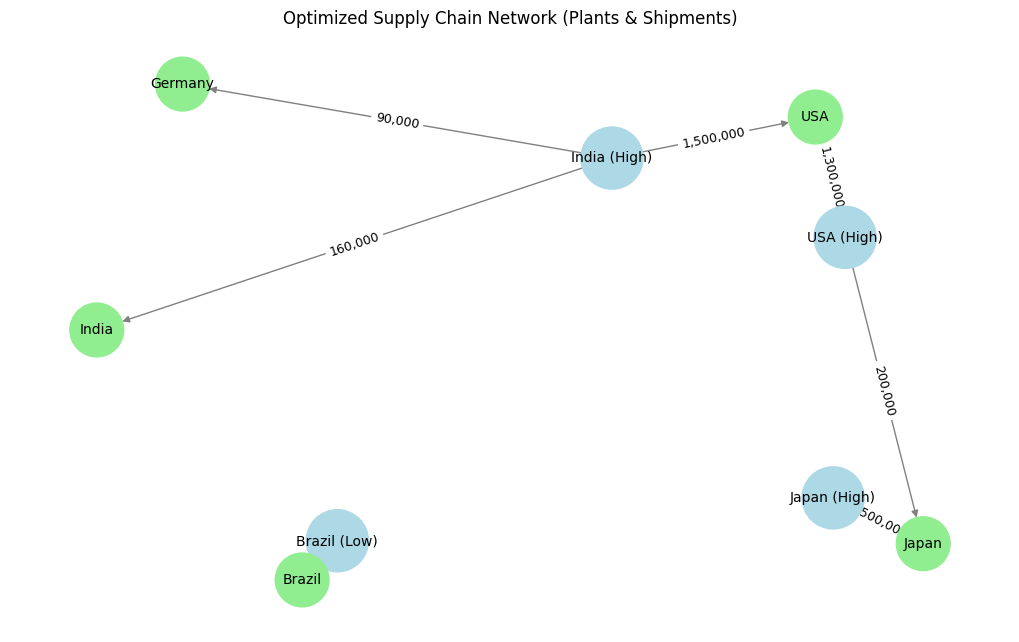

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

# Define supply chain network
G = nx.DiGraph()

# Nodes (Countries & Plants)
plants = ["USA (High)", "India (High)", "Japan (High)", "Brazil (Low)"]
demand_centers = ["USA", "Germany", "Japan", "Brazil", "India"]

# Add nodes
for plant in plants:
    G.add_node(plant, color="lightblue", size=2000)  # Plants
for center in demand_centers:
    G.add_node(center, color="lightgreen", size=1500)  # Demand centers

# Edges (Shipments based on optimization results)
edges = [
    ("Brazil (Low)", "Brazil", 145000),
    ("India (High)", "USA", 1500000),
    ("India (High)", "Germany", 90000),
    ("India (High)", "India", 160000),
    ("Japan (High)", "Japan", 1500000),
    ("USA (High)", "Japan", 200000),
    ("USA (High)", "USA", 1300000),
]

# Add edges with shipment volume as weight
for source, target, volume in edges:
    G.add_edge(source, target, weight=volume)

# Draw the network graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Positioning for aesthetics

# Get node colors and sizes
node_colors = [G.nodes[n]["color"] for n in G.nodes]
node_sizes = [G.nodes[n]["size"] for n in G.nodes]

# Draw nodes and labels
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, edge_color="gray", font_size=10)

# Draw edges with labels
edge_labels = {(u, v): f"{d['weight']:,}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, label_pos=0.5)

plt.title("Optimized Supply Chain Network (Plants & Shipments)")
plt.show()
